# 1-D Hamiltonian system

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Simulation with discrete time steps

x(t) → p(t) → x(t+1) → p(t+1) → x(t+2) → p(t+2) → ...

In [8]:
class HamiltonianSystem:
    def __init__(self, potential_func, dV_dx_func, m, x0, p0, t_max, delta_t):
        # Initialize the Hamiltonian system with given parameters
        self.potential = potential_func  # Potential energy function
        self.dV_dx = dV_dx_func  # Derivative of potential energy function
        self.m = m  # Mass of the particle
        self.x0 = x0  # Initial position
        self.p0 = p0  # Initial momentum
        self.t_max = t_max  # Maximum simulation time
        self.delta_t = delta_t  # Time step
        self.init_energy = 0.5 * (p0**2) / m + self.potential(x0)  # Initial total energy
        self.num_steps = int(t_max / delta_t) + 1  # Number of simulation steps

    def simulate(self):
        # Simulate the Hamiltonian system
        x_array = np.zeros(self.num_steps)  # Array to store positions
        p_array = np.zeros(self.num_steps)  # Array to store momenta
        energy_array = np.zeros(self.num_steps)  # Array to store total energy
        t_array = np.linspace(0, self.t_max, self.num_steps)  # Time array

        # Set initial conditions
        x_array[0], p_array[0], energy_array[0] = self.x0, self.p0, self.init_energy

        # Perform simulation using symplectic Euler method
        for i in range(1, self.num_steps):
            p_array[i] = p_array[i - 1] - self.delta_t * self.dV_dx(x_array[i - 1])
            x_array[i] = x_array[i - 1] + self.delta_t * p_array[i] / self.m
            energy_array[i] = 0.5 * (p_array[i] ** 2) / self.m + self.potential(
                x_array[i]
            )

        return t_array, x_array, p_array, energy_array

    def sample_data(self, t_array, x_array, p_array, energy_array):
        # Sample data at regular intervals for plotting
        sample_interval = int(1 / self.delta_t)
        sample_indices = np.arange(0, self.num_steps, sample_interval)
        return [
            arr[sample_indices] for arr in (t_array, x_array, p_array, energy_array)
        ]

### Plotting

In [9]:
class Plotter:
    @staticmethod
    def static_plots(t_sampled, x_sampled, p_sampled, energy_sampled, init_energy):
        # Create static plots for the Hamiltonian system
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("Hamiltonian System Dynamics", fontsize=16)

        plots = [
            (
                axs[0, 0],
                t_sampled,
                x_sampled,
                "Position vs Time",
                "Time t",
                "Position x(t)",
                "blue",
            ),
            (
                axs[0, 1],
                t_sampled,
                p_sampled,
                "Momentum vs Time",
                "Time t",
                "Momentum p(t)",
                "red",
            ),
            (
                axs[1, 0],
                x_sampled,
                p_sampled,
                "Phase Space Plot",
                "Position x",
                "Momentum p",
                "green",
            ),
            (
                axs[1, 1],
                t_sampled,
                energy_sampled,
                "Total Energy vs Time",
                "Time t",
                "Total Energy H(t)",
                "purple",
            ),
        ]

        # Create each subplot
        for ax, x, y, title, xlabel, ylabel, color in plots:
            ax.plot(x, y, color=color)
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

        # Adjust energy plot to show conservation
        axs[1, 1].set_ylim(init_energy - 0.1, init_energy + 0.1)
        axs[1, 1].axhline(
            y=init_energy, color="black", linestyle="--", label="Initial Energy"
        )
        axs[1, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    @staticmethod
    def composite_plot(x_sampled, t_sampled, potential_func):
        # Create a composite plot showing particle trajectory and potential energy
        fig, (ax_top, ax_bottom) = plt.subplots(
            2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [2, 1]}, sharex=False
        )
        fig.suptitle("Composite Visualization of Hamiltonian System", fontsize=16)

        x_limit_min, x_limit_max = 0, 4 * np.pi
        ax_top.set_xlim(x_limit_min, x_limit_max)
        ax_bottom.set_xlim(x_limit_min, x_limit_max)

        # Plot particle trajectory
        ax_top.plot(x_sampled, t_sampled, color="blue")
        ax_top.set_title("Particle Trajectory")
        ax_top.set_xlabel("Position x(t)")
        ax_top.set_ylabel("Time t")
        ax_top.grid(True)

        # Plot potential energy function
        x_potential = np.linspace(x_limit_min, x_limit_max, 1000)
        V_potential = potential_func(x_potential)
        ax_bottom.plot(x_potential, V_potential, color="black")
        ax_bottom.set_title("Potential Energy V(x) vs Position x")
        ax_bottom.set_xlabel("Position x")
        ax_bottom.set_ylabel("Potential V(x)")
        ax_bottom.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



### Verify confinement

Firstly find the local maxima of the potential function, then check if the particle crossed any of the local maxima.

In [10]:
def verify_confinement(x_sampled, potential_func, epsilon=1e-5):
    # Verify if the particle is confined within potential wells
    # Find the local maxima of the potential function
    x_range = np.linspace(0, 20, 1000)
    potential_values = potential_func(x_range)
    local_maxima_indices = (
        np.where(
            (potential_values[1:-1] > potential_values[:-2])
            & (potential_values[1:-1] > potential_values[2:])
        )[0]
        + 1
    )
    local_maxima = x_range[local_maxima_indices]

    # Check if the particle crossed any of the local maxima
    crossed_barrier = False
    for barrier in local_maxima:
        if np.any(np.abs(x_sampled - barrier) < epsilon):
            crossed_barrier = True
            break

    print("\n>>> Local maxima of the potential function at:", local_maxima)
    print(
        "\n>>> Particle has {}crossed the potential barrier.".format(
            "" if crossed_barrier else "not "
        )
    )


### Main

In [13]:
# Define potential energy function and its derivative
def potential(x):
    return np.sin(x)

def dV_dx(x):
    return np.cos(x)

# Input settings
m = 1.0  # Mass
x0 = 4.0  # Initial position
p0 = 1.0  # Initial momentum
t_max = 30  # Maximum simulation time
delta_t = 0.01  # Time step

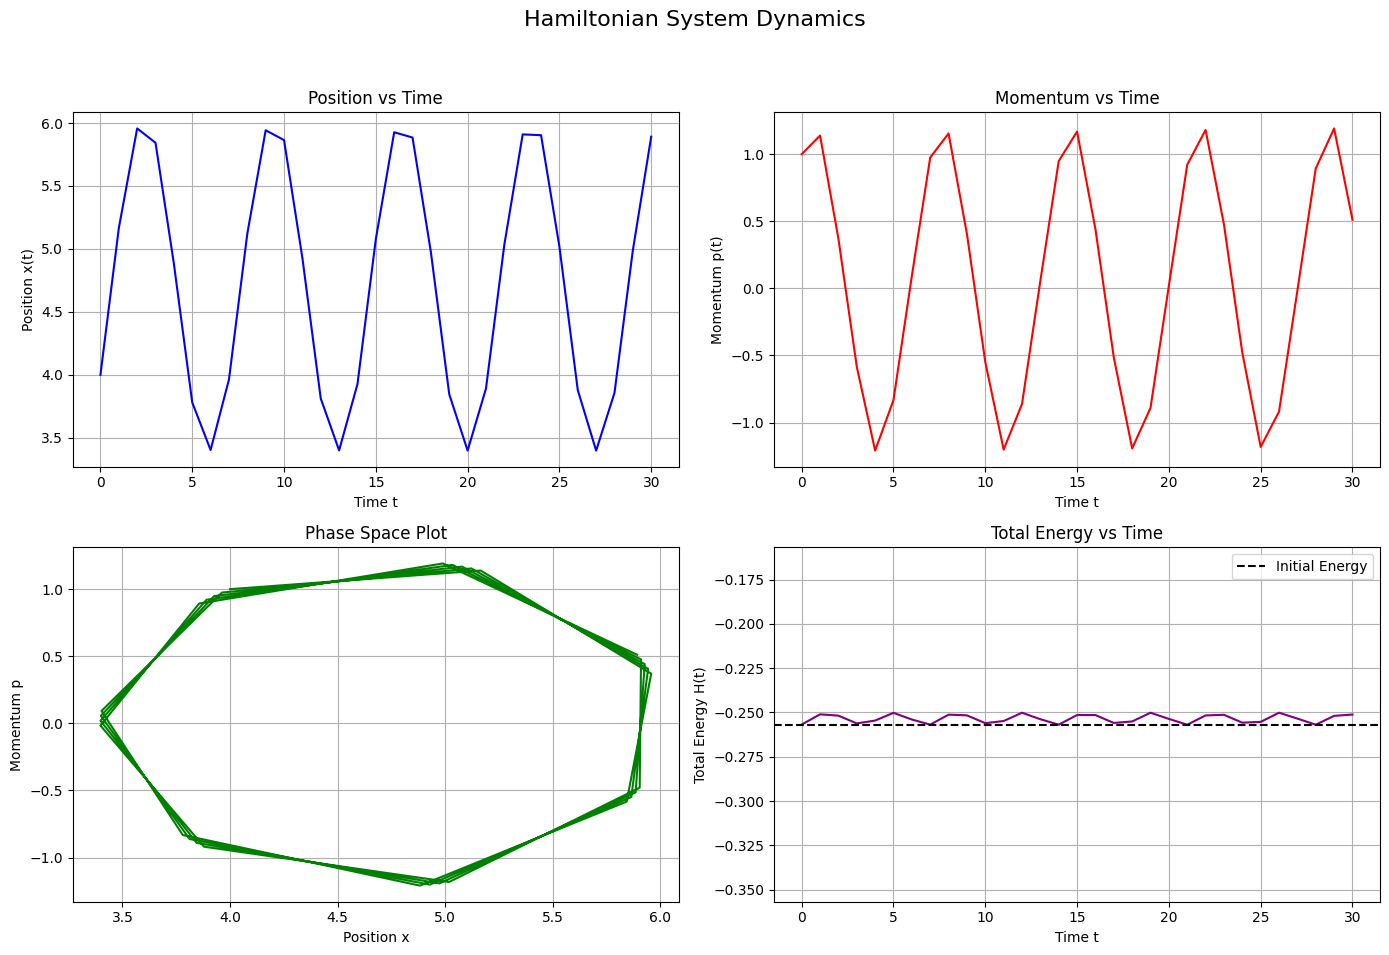

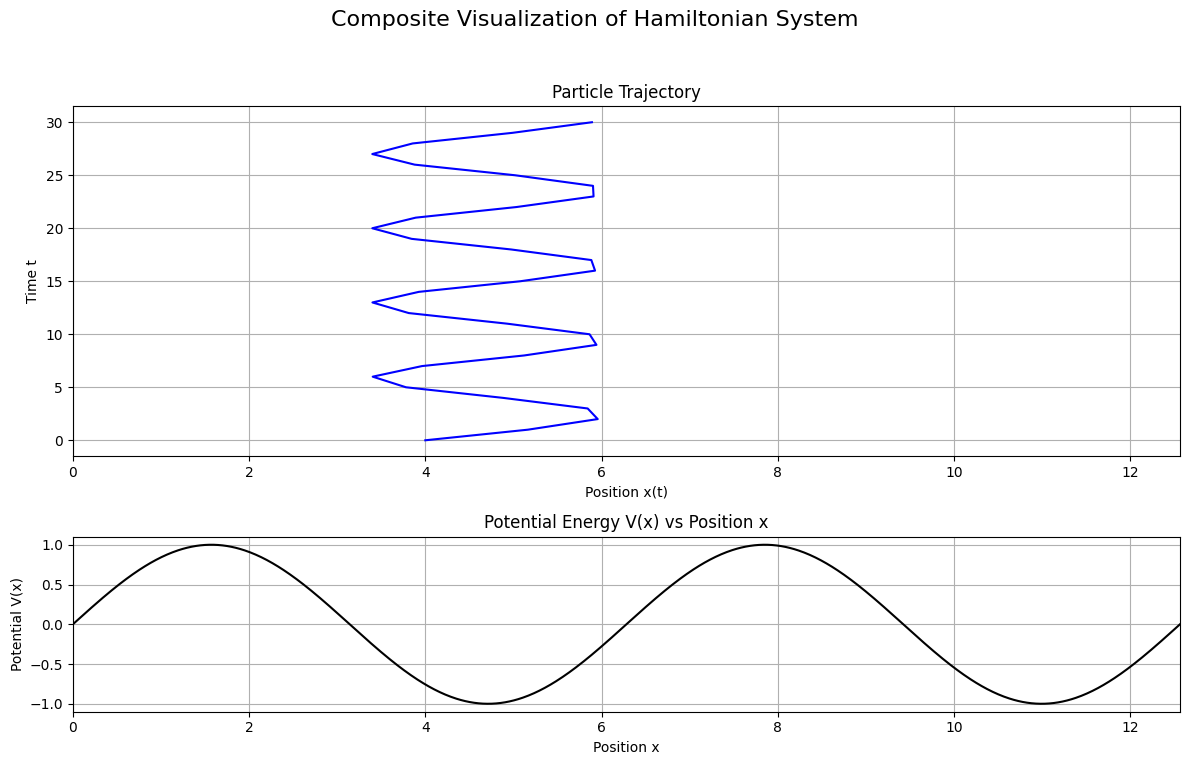


>>> Local maxima of the potential function at: [ 1.56156156  7.84784785 14.13413413]

>>> Particle has not crossed the potential barrier.


In [14]:
# Create and simulate the Hamiltonian system
system = HamiltonianSystem(potential, dV_dx, m, x0, p0, t_max, delta_t)
t_array, x_array, p_array, energy_array = system.simulate()
t_sampled, x_sampled, p_sampled, energy_sampled = system.sample_data(
    t_array, x_array, p_array, energy_array
)

# Create plots
plotter = Plotter()
plotter.static_plots(
    t_sampled, x_sampled, p_sampled, energy_sampled, system.init_energy
)
plotter.composite_plot(x_sampled, t_sampled, potential)

# Verify particle confinement
verify_confinement(x_sampled, potential)